In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

gdf = pd.read_pickle('/srv/scratch/z5297792/FishSOOP/gdf_fishsoo_seaus.pkl')


In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))


In [3]:
gdf

TEMPERATURE  PRES  TEMPERATURE_quality_control  \
TRAJECTORY DEPTH                                                      
0          0.993262    20.378000   1.0                            3   
           1.986520    19.990999   2.0                            1   
           2.979773    19.945999   3.0                            1   
           1.887194    19.973000   1.9                            3   
1          1.092593    24.181000   1.1                            3   
...                          ...   ...                          ...   
5650       6.850858    22.790001   6.9                            1   
           4.865126    22.798000   4.9                            1   
           3.475101    22.799000   3.5                            1   
           1.489336    22.799999   1.5                            1   
           0.000000    22.698999   0.0                            3   

                     DEPTH_quality_control  LATITUDE_quality_control  \
TRAJECTORY DEPTH                                                       
0          0.993262                      1                         1   
           1.986520                      1                         1   
           2.979773                      1                         1   
           1.887194                      1                         1   
1          1.092593                      1                         1   
...                                    ...                       ...   
5650       6.850858                      1                         2   
           4.865126                      1                         2   
           3.475101                      1                         2   
           1.489336                      1                         2   
           0.000000                      1                         2   

                     LONGITUDE_quality_control  PRES_quality_control  \
TRAJECTORY DEPTH                                                       
0          0.993262                          1                     1   
           1.986520                          1                     1   
           2.979773                          1                     1   
           1.887194                          1                     1   
1          1.092593                          1                     1   
...                                        ...                   ...   
5650       6.850858                          2                     1   
           4.865126                          2                     1   
           3.475101                          2                     1   
           1.489336                          2                     1   
           0.000000                          2                     1   

                                             TIME                     geometry  
TRAJECTORY DEPTH                                                                
0          0.993262 2021-11-20 22:24:37.999999744   POINT (153.4339 -29.12272)  
           1.986520 2021-11-20 22:24:41.999999744   POINT (153.4339 -29.12272)  
           2.979773 2021-11-20 22:24:48.000000000   POINT (153.4339 -29.12272)  
           1.887194 2021-11-20 22:25:16.999999744  POINT (153.43385 -29.12276)  
1          1.092593 2021-11-29 08:17:27.000000000   POINT (153.67332 -29.0671)  
...                                           ...                          ...  
5650       6.850858 2025-06-30 13:59:59.000000000   POINT (152.5166 -33.67196)  
           4.865126 2025-06-30 14:00:01.000000000   POINT (152.5166 -33.67196)  
           3.475101 2025-06-30 14:00:02.000000000   POINT (152.5166 -33.67196)  
           1.489336 2025-06-30 14:00:03.000000000   POINT (152.5166 -33.67196)  
           0.000000 2025-06-30 14:00:04.000000000   POINT (152.5166 -33.67196)  

[2889960 rows x 9 columns]

In [4]:
gdf.geometry.y

TRAJECTORY  DEPTH   
0           0.993262   -29.122721
            1.986520   -29.122721
            2.979773   -29.122721
            1.887194   -29.122759
1           1.092593   -29.067102
                          ...    
5650        6.850858   -33.671963
            4.865126   -33.671963
            3.475101   -33.671963
            1.489336   -33.671963
            0.000000   -33.671963
Length: 2889960, dtype: float64

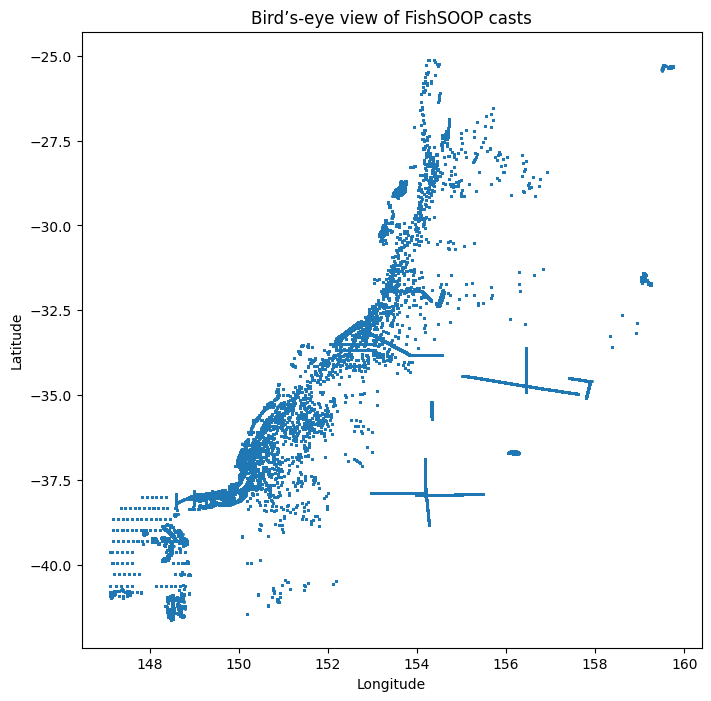

In [5]:
import matplotlib.pyplot as plt

# Extract lon, lat from geometry
lons = gdf.geometry.x
lats = gdf.geometry.y

plt.figure(figsize=(8, 8))
plt.scatter(lons, lats, s=1, alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Bird’s-eye view of FishSOOP casts")
plt.show()


In [6]:
x0, x1 = (np.float64(146.65652923583986), np.float64(156.44457550048827))
y0, y1 = (np.float64(-42.43737716674805), np.float64(-24.292496490478516))
z0, z1 = (np.float64(1.3167407676111906), np.float64(-0.07310091010294854))


(np.float64(146.3440976390258), np.float64(162.97394958045817)) (np.float64(-42.36726256191239), np.float64(-24.296304944101717)) (np.float64(5.189159166056557), np.float64(-0.24835077733013808))


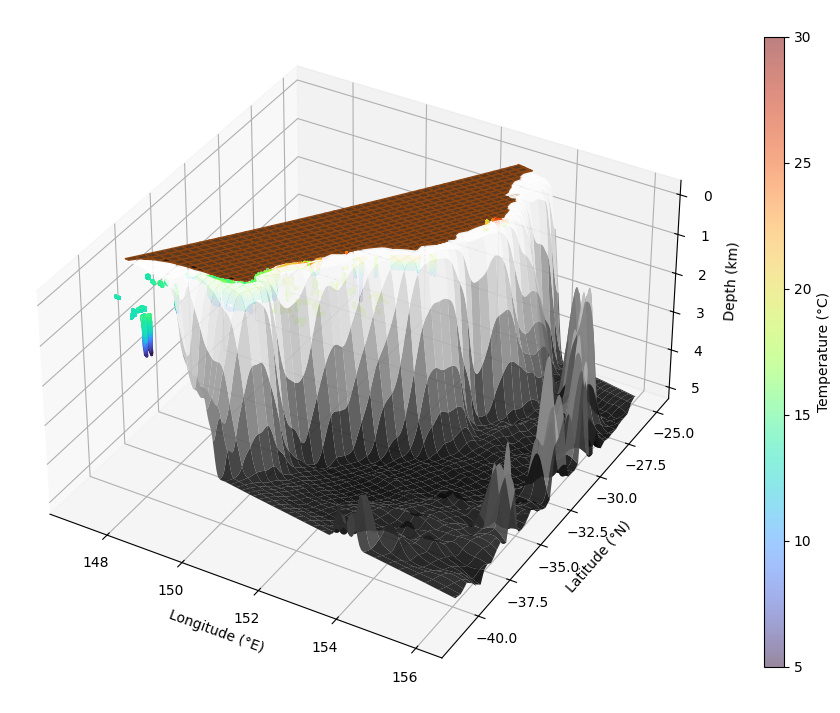

In [7]:
max_len = round(len(gdf.geometry.x)/10)
# max_len = len(gdf.geometry.x)
# Subset for speed
depth = gdf['DEPTH'] if 'DEPTH' in gdf.columns else gdf.index.get_level_values('DEPTH')
df_temp = pd.DataFrame({
    'Lon': gdf.geometry.x[:max_len],
    'Lat': gdf.geometry.y[:max_len],
    'Depth': depth[:max_len] / 1000,
    'Temp': gdf['TEMPERATURE'][:max_len]
})
# sort by latitude (ascending)
df_temp = df_temp.sort_values("Lat", ascending=False).reset_index(drop=True)
df_temp = df_temp[df_temp.Lon <= 156]

m = np.isfinite(df_temp.Lon) & np.isfinite(df_temp.Lat) & np.isfinite(df_temp.Depth) & np.isfinite(df_temp.Temp)

fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(
    lon_rho, lat_rho, np.where(mask_rho==0, 0, np.nan),
    facecolors=np.where(mask_rho==0, 'saddlebrown', 'none'),
    edgecolor="saddlebrown", alpha=0.9, zorder=1
)

h_mask = np.where(mask_rho, h, np.nan)/1000
ax.plot_surface(
    lon_rho, lat_rho, np.where((lon_rho>=x0)&(lon_rho<=x1)&(lat_rho>=y0)&(lat_rho<=y1), h_mask, np.nan),
    cmap="Greys", edgecolor="none", alpha=0.9, zorder=0
)

sc = ax.scatter(
    df_temp.Lon[m], df_temp.Lat[m], df_temp.Depth[m], zorder=2,
    c=df_temp.Temp[m], cmap="turbo", s=1, alpha=0.5, vmin=5, vmax=30)

ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)')
ax.set_zlabel('Depth (km)')
ax.invert_zaxis()

dx, dy, dz = np.ptp(ax.get_xlim()), np.ptp(ax.get_ylim()), np.ptp(ax.get_zlim())
ax.set_box_aspect([dx, dy, 10])

print(ax.get_xlim(), ax.get_ylim(), ax.get_zlim())

ax.view_init(elev=35, azim=-60)
ax.set_xlim(x0, x1); ax.set_ylim(y0, y1); #ax.set_zlim(z0, z1);

cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(sc, cax=cax, label="Temperature (°C)")

plt.show()



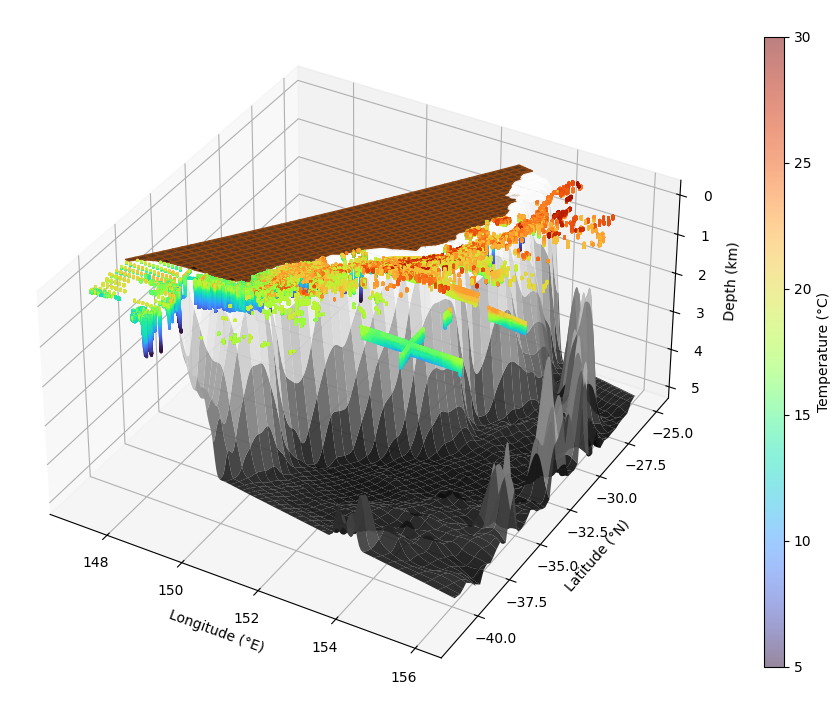

In [13]:
# max_len = round(len(gdf.geometry.x)/10)
max_len = len(gdf.geometry.x)
# Subset for speed
depth = gdf['DEPTH'] if 'DEPTH' in gdf.columns else gdf.index.get_level_values('DEPTH')
df_temp = pd.DataFrame({
    'Lon': gdf.geometry.x[:max_len],
    'Lat': gdf.geometry.y[:max_len],
    'Depth': depth[:max_len] / 1000,
    'Temp': gdf['TEMPERATURE'][:max_len]
})
# sort by latitude (ascending)
df_temp = df_temp.sort_values("Lat", ascending=False).reset_index(drop=True)
df_temp = df_temp[df_temp.Lon <= 156]

m = np.isfinite(df_temp.Lon) & np.isfinite(df_temp.Lat) & np.isfinite(df_temp.Depth) & np.isfinite(df_temp.Temp)


fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(111, projection='3d')

# --- land surface
surf_land = ax.plot_surface(
    lon_rho, lat_rho, np.where(mask_rho==0, 0, np.nan),
    facecolors=np.where(mask_rho==0, 'saddlebrown', 'none'),
    edgecolor="saddlebrown", alpha=0.9, zorder=0
)
surf_land.set_sort_zpos(-1e9)

# --- bathy surface (windowed)
h_mask = np.where(mask_rho, h, np.nan)/1000
surf_bathy = ax.plot_surface(
    lon_rho, lat_rho, np.where((lon_rho>=x0)&(lon_rho<=x1)&(lat_rho>=y0)&(lat_rho<=y1), h_mask, np.nan),
    cmap="Greys", edgecolor="none", alpha=0.9, zorder=0
)
surf_bathy.set_sort_zpos(-1e9)

# --- scatter on top
sc = ax.scatter(
    df_temp.Lon[m], df_temp.Lat[m], df_temp.Depth[m],
    c=df_temp.Temp[m], cmap="turbo", s=1, alpha=0.5, vmin=5, vmax=30,
    depthshade=False, zorder=10
)
sc.set_sort_zpos(1e9)

ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)')
ax.set_zlabel('Depth (km)')
ax.invert_zaxis()

dx, dy, dz = np.ptp(ax.get_xlim()), np.ptp(ax.get_ylim()), np.ptp(ax.get_zlim())
ax.set_box_aspect([dx, dy, 10])

ax.view_init(elev=35, azim=-60)
ax.set_xlim(x0, x1); ax.set_ylim(y0, y1)

cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(sc, cax=cax, label="Temperature (°C)")
plt.show()


### POLISHED

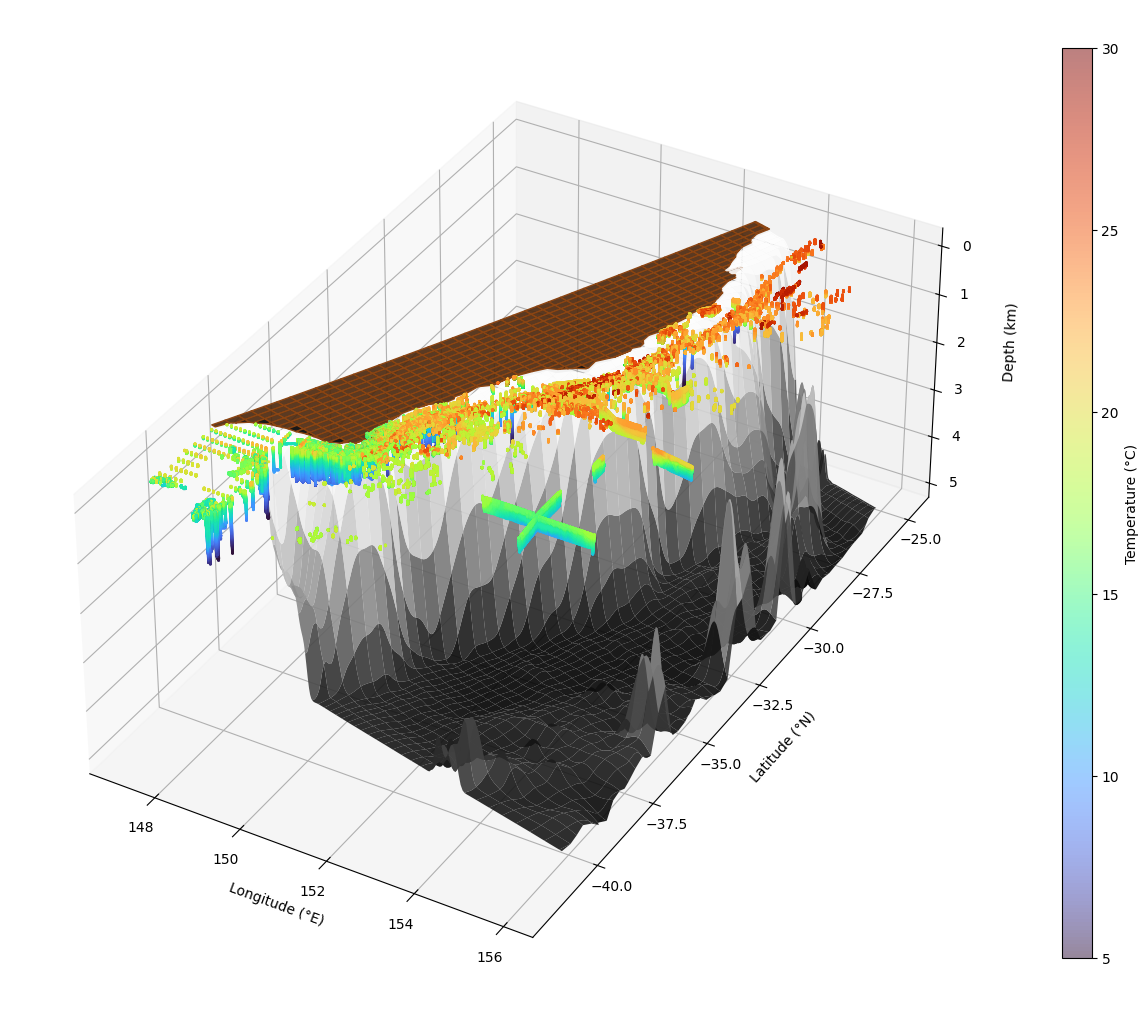

In [36]:
# max_len = round(len(gdf.geometry.x)/10)
max_len = len(gdf.geometry.x)
# Subset for speed
depth = gdf['DEPTH'] if 'DEPTH' in gdf.columns else gdf.index.get_level_values('DEPTH')
df_temp = pd.DataFrame({
    'Lon': gdf.geometry.x[:max_len],
    'Lat': gdf.geometry.y[:max_len],
    'Depth': depth[:max_len] / 1000,
    'Temp': gdf['TEMPERATURE'][:max_len]
})
df_temp = df_temp.sort_values("Lat", ascending=False).reset_index(drop=True)
df_temp = df_temp[df_temp.Lon <= 156]
m = np.isfinite(df_temp.Lon) & np.isfinite(df_temp.Lat) & np.isfinite(df_temp.Depth) & np.isfinite(df_temp.Temp)

fig = plt.figure(figsize=(15,13))
ax = fig.add_subplot(111, projection='3d')

# --- land surface
surf_land = ax.plot_surface(
    lon_rho, lat_rho, np.where(mask_rho==0, 0, np.nan),
    facecolors=np.where(mask_rho==0, 'saddlebrown', 'none'),
    edgecolor="saddlebrown", alpha=0.9, zorder=0
)
surf_land.set_sort_zpos(-1e9)

# --- bathy surface (windowed)
h_mask = np.where(mask_rho, h, np.nan)/1000
surf_bathy = ax.plot_surface(
    lon_rho, lat_rho, np.where((lon_rho>=x0)&(lon_rho<=x1)&(lat_rho>=y0)&(lat_rho<=y1), h_mask, np.nan),
    cmap="Greys", edgecolor="none", alpha=0.9, zorder=0
)
surf_bathy.set_sort_zpos(-1e9)

# --- scatter on top
sc = ax.scatter(
    df_temp.Lon[m], df_temp.Lat[m], df_temp.Depth[m],
    c=df_temp.Temp[m], cmap="turbo", s=1, alpha=0.5, vmin=5, vmax=30,
    depthshade=False, zorder=10
)
sc.set_sort_zpos(1e9)

ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)', labelpad=15)
ax.set_zlabel('Depth (km)', labelpad=15)
ax.invert_zaxis()

# dx, dy, dz = np.ptp(ax.get_xlim()), np.ptp(ax.get_ylim()), np.ptp(ax.get_zlim())
ax.set_box_aspect([15, 25, 10])

ax.view_init(elev=35, azim=-60)
ax.set_xlim(x0, x1); ax.set_ylim(y0, y1)

cax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(sc, cax=cax, label="Temperature (°C)")
plt.show()


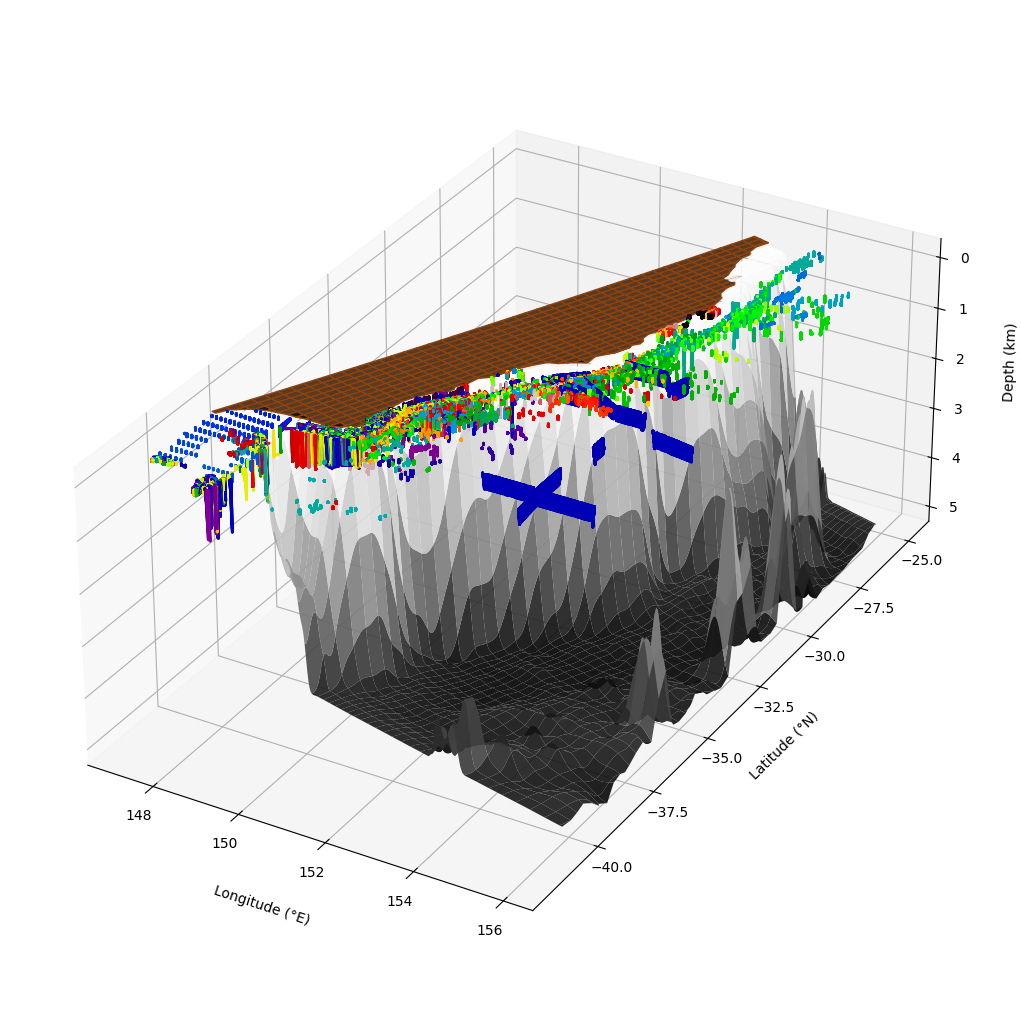

In [35]:
max_len = len(gdf.geometry.x)
# max_len = round(len(gdf.geometry.x)/10)
depth = gdf['DEPTH'] if 'DEPTH' in gdf.columns else gdf.index.get_level_values('DEPTH')
casts = gdf['TRAJECTORY'] if 'TRAJECTORY' in gdf.columns else gdf.index.get_level_values('TRAJECTORY')
df_cast = pd.DataFrame({
    'Lon': gdf.geometry.x[:max_len],
    'Lat': gdf.geometry.y[:max_len],
    'Depth': depth[:max_len] / 1000,
    'Cast': casts[:max_len]
})
df_cast = df_cast.sort_values("Lat", ascending=False).reset_index(drop=True)
df_cast = df_cast[df_cast.Lon <= 156]

codes, uniques = pd.factorize(df_cast.Cast)   # integer 0..K-1 per cast

m = np.isfinite(df_cast.Lon) & np.isfinite(df_cast.Lat) & np.isfinite(df_cast.Depth) & np.isfinite(df_cast.Cast)

fig = plt.figure(figsize=(15,13))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(
    lon_rho, lat_rho, np.where(mask_rho==0, 0, np.nan),
    facecolors=np.where(mask_rho==0, 'saddlebrown', 'none'),
    edgecolor="saddlebrown", alpha=0.9, zorder=1
)

h_mask = np.where(mask_rho, h, np.nan)/1000
ax.plot_surface(
    lon_rho, lat_rho, np.where((lon_rho>=x0)&(lon_rho<=x1)&(lat_rho>=y0)&(lat_rho<=y1), h_mask, np.nan),
    cmap="Greys", edgecolor="none", alpha=0.9, zorder=0
)

sc = ax.scatter(
    df_cast.Lon[m], df_cast.Lat[m], df_cast.Depth[m],
    c=df_cast.Cast[m], cmap="nipy_spectral", s=1, alpha=0.6, zorder=2
)

ax.set_xlabel('Longitude (°E)', labelpad=15)
ax.set_ylabel('Latitude (°N)', labelpad=15)
ax.set_zlabel('Depth (km)', labelpad=15)
ax.invert_zaxis()
# dx, dy, dz = np.ptp(ax.get_xlim()), np.ptp(ax.get_ylim()), np.ptp(ax.get_zlim())
ax.set_box_aspect([15, 25, 10])

ax.view_init(elev=30, azim=-60)
ax.set_xlim(x0, x1); ax.set_ylim(y0, y1); #ax.set_zlim(z0, z1);

# cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# fig.colorbar(sc, cax=cax, label="Cast")

plt.show()
